In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df.shape

(1319, 12)

## Preparation

In [5]:
df['card_num']=(df.card=='yes').astype(int)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df_full_train,df_test=train_test_split(df,random_state=1,test_size=0.2)
df_train,df_val=train_test_split(df_full_train,random_state=1,test_size=0.25)

In [8]:
len(df_train),len(df_val),len(df_test)

(791, 264, 264)

In [9]:
y_full_train=df_full_train.card_num.values
y_train=df_train.card_num.values
y_test=df_test.card_num.values
y_val=df_val.card_num.values

In [10]:
del df_train['card_num']
del df_train['card']
del df_test['card_num']
del df_test['card']
del df_val['card_num']
del df_val['card']

## Question 1

Which numerical variable (among the following 4) has the highest AUC?

In [11]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
card_num         int32
dtype: object

In [12]:
numerical=['reports','age','income','share','expenditure','dependents','months','active']

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [14]:
for col in numerical:
    fpr, tpr, thresholds= roc_curve(y_train,df_train[col])
    if auc(fpr,tpr)<0.5:
        fpr, tpr, thresholds= roc_curve(y_train,-df_train[col])
        print('-',col,round(auc(fpr,tpr),4))
    else:
        print('+',col,round(auc(fpr,tpr),4))

- reports 0.7167
- age 0.524
+ income 0.5908
+ share 0.9892
+ expenditure 0.991
- dependents 0.5328
- months 0.5294
+ active 0.6043


**Highest AUC is share**

## Training the model

In [15]:
colu= ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [16]:
from sklearn.feature_extraction import DictVectorizer

In [17]:
dv=DictVectorizer(sparse=False)

In [18]:
train_dict=df_train[colu].to_dict(orient='records')
X_train=dv.fit_transform(train_dict)

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [21]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [22]:
val_dict=df_val[colu].to_dict(orient='records')
X_val=dv.transform(val_dict)
y_pred=model.predict_proba(X_val)[:,1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [23]:
from sklearn.metrics import roc_auc_score
print ('AUC for model is',round(roc_auc_score(y_val,y_pred),3))

AUC for model is 0.995


## Question 3

At which threshold precision and recall curves intersect?

In [24]:
prec=[]
rec=[]
for i in np.linspace(0,0.99,100):
    dec=(y_pred>i).astype(int)
    tp=((dec==1) & (y_val==1)).sum()
    fp=((dec==1) & (y_val==0)).sum()
    fn=((dec==0) & (y_val==1)).sum()
    p= tp/(tp+fp)
    prec.append(p)
    r=tp/(tp+fn)
    rec.append(r)

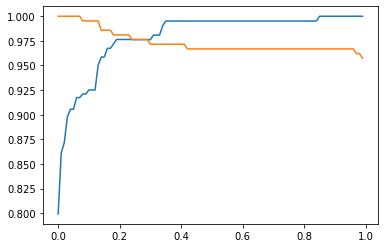

In [25]:
plt.plot(np.linspace(0,0.99,100),prec)
plt.plot(np.linspace(0,0.99,100),rec)

**Curve meet at 0.3**

## Question 4

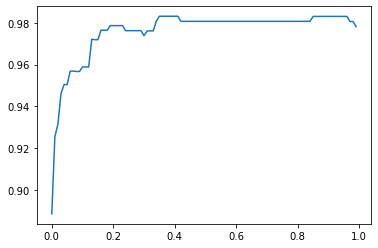

In [26]:
prec=[]
rec=[]
F1=[]
for i in np.linspace(0,0.99,100):
    dec=(y_pred>i).astype(int)
    tp=((dec==1) & (y_val==1)).sum()
    fp=((dec==1) & (y_val==0)).sum()
    fn=((dec==0) & (y_val==1)).sum()
    p= tp/(tp+fp)
    prec.append(p)
    r=tp/(tp+fn)
    rec.append(r)
    f1 = 2 * p * r / (p + r)
    F1.append(f1)
plt.plot(np.linspace(0,0.99,100),F1)

**F1 is max at 0.4**

## Question 5

How large is standard devidation of the AUC scores across different folds?

In [27]:
from sklearn.model_selection import KFold

In [28]:
kfold=KFold(n_splits=5, shuffle=True, random_state=1)

In [29]:
scores=[]
for train_idx,val_idx in kfold.split(df_full_train):
    df_train=df_full_train[colu].iloc[train_idx]
    df_val=df_full_train[colu].iloc[val_idx]
    y_train=df_full_train['card_num'].iloc[train_idx].values
    y_val=df_full_train['card_num'].iloc[val_idx].values
    train_dict=df_train.to_dict(orient='records')
    val_dict=df_val.to_dict(orient='records')
    X_train=dv.fit_transform(train_dict)
    X_val=dv.transform(val_dict)
    model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train,y_train)
    y_pred=model.predict_proba(X_val)[:,1]
    score=roc_auc_score(y_val,y_pred)
    scores.append(score)

In [42]:
print('standard deviation is',round(np.std(scores),3))

standard deviation is 0.003


## Question 6
Which C leads to the best mean score?

In [41]:
C=[0.01, 0.1, 1, 10]

In [46]:

for c in C:
    kfold=KFold(n_splits=5, shuffle=True, random_state=1)
    scores=[]
    for train_idx,val_idx in kfold.split(df_full_train):
        df_train=df_full_train[colu].iloc[train_idx]
        df_val=df_full_train[colu].iloc[val_idx]
        y_train=df_full_train['card_num'].iloc[train_idx].values
        y_val=df_full_train['card_num'].iloc[val_idx].values
        train_dict=df_train.to_dict(orient='records')
        val_dict=df_val.to_dict(orient='records')
        X_train=dv.fit_transform(train_dict)
        X_val=dv.transform(val_dict)
        model=LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train,y_train)
        y_pred=model.predict_proba(X_val)[:,1]
        score=roc_auc_score(y_val,y_pred)
        scores.append(score)
    print('C =', c)
    print('mean score =', round(np.mean(scores),3))
    print('standard dev =', round(np.std(scores),3))
    print()

C = 0.01
mean score = 0.992
standard dev = 0.006

C = 0.1
mean score = 0.995
standard dev = 0.004

C = 1
mean score = 0.996
standard dev = 0.003

C = 10
mean score = 0.996
standard dev = 0.003



**C with min mean score is 0.01**